# 这个文件用来帮助我们了解 Faster R-CNN 如何调用/训练。微调

论文地址：https://arxiv.org/pdf/1506.01497

In [1]:
import torch
import torchvision

# load faster r-cnn model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# print the structure of the model
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

time: 0.027791500091552734
boxes:
 tensor([[ 27.0336,  49.1231,  30.9291,  56.4841],
        [114.9010, 153.4554, 120.1455, 167.4097],
        [153.2221, 102.2977, 157.2692, 111.9737],
        [148.7191, 102.8726, 153.2488, 113.3044],
        [167.2151, 102.1072, 170.2648, 111.5816],
        [  1.7980, 126.2398,  33.7636, 156.4111],
        [ 68.0727,  15.3137, 110.5104,  50.9811],
        [198.7487,  65.7596, 226.4521,  85.3613],
        [124.5687,  87.7797, 127.8754, 100.4415],
        [173.6476,  76.4650, 182.1704,  94.1710],
        [115.1846, 153.8555, 119.2142, 162.1573],
        [199.7064,  66.2123, 225.8395,  85.3078],
        [151.7744,  89.0211, 155.8267,  97.2898],
        [259.7130, 131.0054, 270.1659, 143.1775],
        [178.0463,  76.4749, 187.6449,  91.7895],
        [179.4779,   3.3167, 182.2604,  11.2773],
        [177.5726,  77.0885, 182.7613,  92.9371],
        [165.0227,  83.4289, 167.9081,  94.5132],
        [  5.2897,   7.8084, 214.4565, 160.3138],
        [199.54

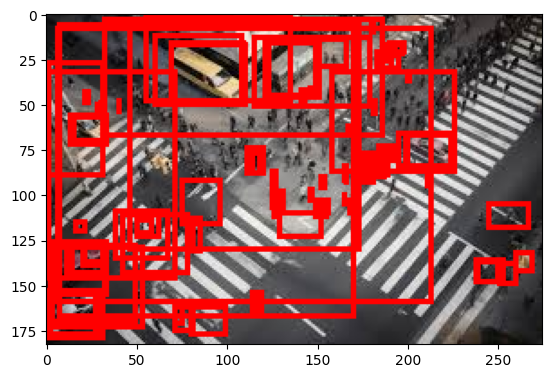

In [7]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import time

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

def get_prediction(img, threshold):
    
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    # get the prediction box
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    
    # get the index of the boxes that pass the threshold
    idx = [i for i in range(len(scores)) if scores[i] > threshold]
    
    # get the boxes that pass the threshold
    boxes = boxes[idx]
    labels = labels[idx]
    scores = scores[idx]
    
    return boxes, labels, scores

def plot_image(img_path, boxes):
    # load image
    img = Image.open(img_path)
    
    # draw boxes
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)
    
    # plot image
    plt.imshow(img)
    plt.show()

# get prediction
img_path = 'test_image.jpg'
# img_path = 'test_image2.png'
threshold = 0.
img = load_image(img_path).cuda()
t0 = time.time()
boxes, labels, scores = get_prediction(img, threshold)
t1 = time.time()
print('time:', t1-t0)
print("boxes:\n", boxes)
print("labels:\n", labels)
print("scores:\n", scores)
plot_image(img_path, boxes)